# Tutorial 40: Mean Relativistic Value at Risk (RLVaR) Optimization

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'AMZN', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'AAPL', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].iloc[-300:,:].pct_change().dropna()

display(Y.head())

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-19,1.5230%,-0.3778%,0.0475%,-0.8599%,-1.4332%,-3.0011%,0.1113%,1.2968%,3.4361%,-0.8764%,...,1.6741%,0.1475%,0.6339%,-0.1823%,-0.7728%,1.1385%,-1.1144%,-1.2872%,0.4575%,-0.8025%
2018-10-22,0.6110%,1.4325%,-1.9240%,-0.0786%,-0.6335%,-6.2983%,-0.6392%,-1.1024%,0.0527%,-0.3221%,...,-1.0331%,0.8927%,-0.8661%,0.4483%,-2.8972%,-0.6085%,-0.6075%,-0.8635%,0.1457%,-3.4490%
2018-10-23,0.9427%,-1.1513%,-3.6571%,-1.6658%,-0.4202%,-0.4521%,-0.2797%,-0.5034%,0.1845%,-3.9948%,...,0.8808%,-1.3956%,0.4766%,-5.1240%,-0.0321%,1.0713%,-1.0807%,-1.8308%,4.0560%,4.0353%
2018-10-24,-3.4302%,-5.9083%,-4.5500%,1.3141%,-1.8042%,-3.5933%,-4.2917%,0.8674%,0.9995%,-4.1109%,...,0.7437%,-5.3469%,3.5178%,-4.2683%,-1.3479%,-8.0557%,-1.2403%,-4.2187%,0.3671%,-3.3065%
2018-10-25,2.1898%,7.0887%,0.4741%,2.5716%,0.5186%,0.7782%,5.0410%,-0.5733%,-1.1719%,2.1585%,...,1.3642%,5.8444%,-1.0309%,0.4913%,0.9109%,-1.2516%,4.3662%,1.3800%,-1.7241%,3.3538%


## 2. Estimating Mean Relativistic Value at Risk (RLVaR) Portfolios

### Mean Relativistic Value at Risk (RLVaR) 포트폴리오 모델 설명

**Mean Relativistic Value at Risk (RLVaR)** 포트폴리오 모델은 전통적인 VaR(Value at Risk)와 유사하지만, 보다 현실적인 시장 상황을 반영하기 위해 상대론적 접근법을 사용합니다. RLVaR는 포트폴리오의 손실 가능성을 측정하고, 투자자의 리스크 선호도에 맞춘 최적화를 가능하게 합니다.

### RLVaR 정의

RLVaR는 특정 신뢰수준에서 포트폴리오의 최대 예상 손실을 측정합니다. 이는 전통적인 VaR가 단일 기간의 최대 손실을 측정하는 것과 달리, RLVaR는 상대론적 접근을 통해 시장의 변동성을 더 잘 반영합니다.

### RLVaR를 사용한 포트폴리오 최적화

RLVaR를 사용한 포트폴리오 최적화는 다음과 같은 형태를 취합니다:

1. **목표 함수 (Objective Function)**:
   $$ \min_w \, \text{RLVaR}(w) $$
   여기서 $ w $는 포트폴리오 가중치 벡터입니다.

2. **제약 조건 (Constraints)**:
   - 가중치의 합은 1이어야 합니다:
     $$ \sum_{i=1}^{n} w_i = 1 $$
   - 각 자산의 가중치는 특정 범위 내에 있어야 합니다:
     $$ l_i \leq w_i \leq u_i $$

### RLVaR 포트폴리오 최적화 예제 코드

아래는 `Riskfolio-Lib`를 사용하여 RLVaR 포트폴리오를 최적화하는 예제 코드입니다:

```python
import numpy as np
import pandas as pd
import riskfolio as rp
import matplotlib.pyplot as plt

# 예시 데이터 생성
np.random.seed(42)
Y = np.random.randn(100, 10)  # 100개의 샘플과 10개의 자산
asset_names = [f'Asset {i}' for i in range(1, 11)]
returns = pd.DataFrame(Y, columns=asset_names)

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=returns)

# 기대 수익률 및 공분산 행렬 추정
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# 최적화 매개변수 설정
model = 'Classic'  # 사용할 모델: Classic (historical), BL (Black Litterman), FM (Factor Model)
rm = 'RLVaR'  # 리스크 측정치로 RLVaR 사용
obj = 'Sharpe'  # 목표 함수: Sharpe 비율 최대화
hist = True  # 역사적 시나리오 사용 여부
rf = 0  # 무위험 이자율
l = 0  # 리스크 회피 계수 (유틸리티 목표 함수에서만 사용)

# 최적 포트폴리오 계산
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# 히스토그램 플롯
ax = rp.plot_hist(returns=Y, w=w, alpha=0.05, bins=50, height=6, width=10, ax=None)

# 플롯 표시
plt.show()
```

### 코드 설명

1. **데이터 준비 및 포트폴리오 객체 생성**:
   ```python
   np.random.seed(42)
   Y = np.random.randn(100, 10)
   asset_names = [f'Asset {i}' for i in range(1, 11)]
   returns = pd.DataFrame(Y, columns=asset_names)
   port = rp.Portfolio(returns=returns)
   ```

   - 예시 데이터를 생성하고 자산 이름을 설정합니다.
   - `rp.Portfolio` 클래스를 사용하여 포트폴리오 객체를 생성합니다.

2. **기대 수익률 및 공분산 행렬 추정**:
   ```python
   method_mu = 'hist'
   method_cov = 'hist'
   port.assets_stats(method_mu=method_mu, method_cov=method_cov)
   ```

   - 역사적 데이터를 기반으로 기대 수익률 및 공분산 행렬을 추정합니다.

3. **최적화 매개변수 설정**:
   ```python
   model = 'Classic'
   rm = 'RLVaR'
   obj = 'Sharpe'
   hist = True
   rf = 0
   l = 0
   ```

   - 클래식 모델을 사용하고, RLVaR를 리스크 측정치로 설정하며, 목표 함수를 Sharpe 비율 최대화로 설정합니다.
   - 역사적 시나리오를 사용하며, 무위험 이자율은 0으로 설정합니다.

4. **최적 포트폴리오 계산**:
   ```python
   w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
   ```

   - 지정된 매개변수에 따라 포트폴리오를 최적화합니다.

5. **히스토그램 플롯 및 표시**:
   ```python
   ax = rp.plot_hist(returns=Y, w=w, alpha=0.05, bins=50, height=6, width=10, ax=None)
   plt.show()
   ```

   - `plot_hist` 함수를 사용하여 히스토그램을 플롯하고, 최적화된 포트폴리오의 수익률 분포를 시각화합니다.

### 결론

Mean Relativistic Value at Risk (RLVaR) 포트폴리오 모델은 시장의 변동성을 현실적으로 반영하는 리스크 관리 접근법을 제공합니다. RLVaR를 사용하면 투자자의 리스크 선호도에 맞춘 포트폴리오 최적화를 통해 극단적 손실을 효과적으로 관리할 수 있습니다. 위 예제 코드는 RLVaR 포트폴리오를 최적화하는 방법을 보여주며, 다양한 투자 전략을 검토하고 실행하는 데 도움이 됩니다.

Cajas(2023)가 제안한 Relativistic Value at Risk (RLVaR) 포트폴리오 모델은 포트폴리오 수익률의 RLVaR을 포트폴리오의 Entropic Value at Risk (EVaR)와 유사한 방식으로 최적화하는 방법을 보여줍니다. RLVaR은 Kaniadakis 엔트로피에 기반한 EVaR의 일반화된 형태로, 일관된 리스크 측정치입니다.

RLVaR 모델은 파워 콘(power cone)을 사용하므로 RLVaR을 최적화할 때 MOSEK를 사용하는 것이 권장됩니다.

MOSEK 설치 지침은 다음 링크에서 확인할 수 있으며, Anaconda를 사용하는 것이 좋습니다. 또한, 학술용 라이선스를 요청하는 것을 권장합니다.

- [MOSEK 설치 지침](https://www.mosek.com/products/academic-licenses/)

### 2.1 Calculating the portfolio that optimize return/RLVaR ratio.

In [3]:
import riskfolio as rp
import mosek

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov,
                  )

# Estimate optimal portfolio:

port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing GMD
port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

kappa = 0.3
alpha = 0.05
port.kappa = kappa
port.alpha = alpha

model ='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'RLVaR' # Risk measure used, this time will be Tail Gini Range
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
weights,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,7.9142%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,6.5198%,0.0000%,15.5153%,0.0000%,0.0000%,0.0000%


### 2.2 Plotting portfolio composition

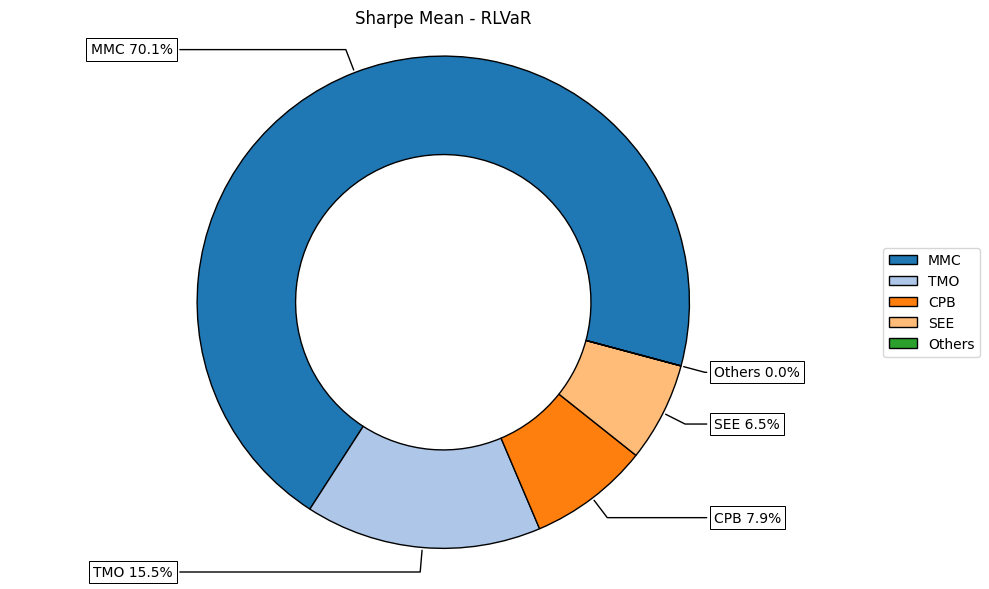

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='Sharpe Mean - RLVaR',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

### 2.3 Plotting risk measures

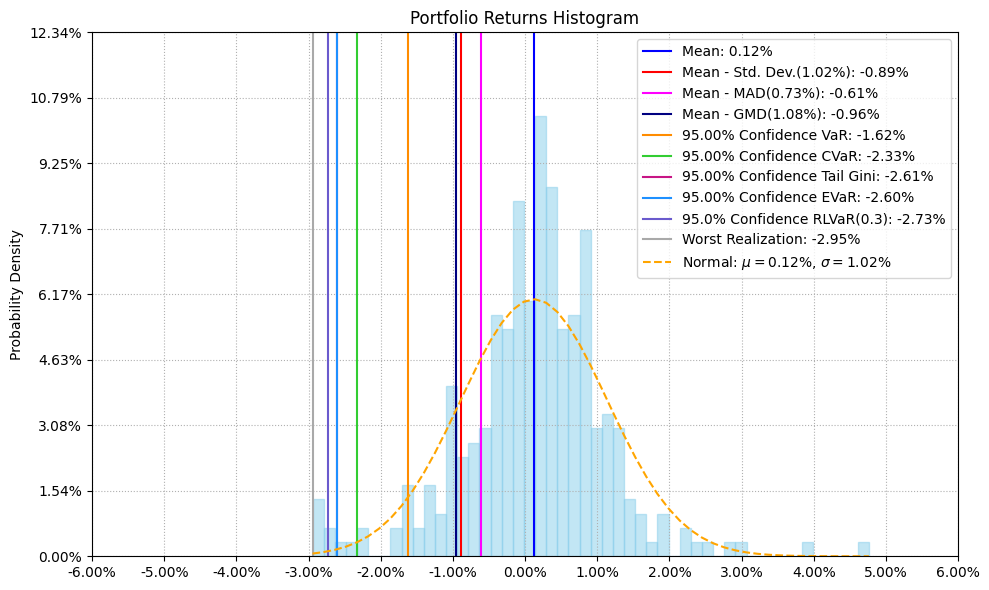

In [5]:
ax = rp.plot_hist(returns=Y,
                  w=w,
                  alpha=alpha,
                  kappa=kappa,
                  solver='MOSEK',
                  bins=50,
                  height=6,
                  width=10,
                  ax=None)

### 2.4 Calculate efficient frontier

In [6]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
0,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,10.6569%,4.7597%,0.0000%,0.0000%,0.0000%,...,23.5627%,0.0000%,2.0759%,0.0000%,17.4819%,0.0000%,0.0000%,0.0000%,29.5795%,5.5920%
1,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,12.5233%,18.4968%,0.0000%,0.0000%,0.0000%,...,16.0178%,0.0000%,0.0000%,0.0000%,12.8766%,0.0000%,0.0000%,0.0000%,27.7296%,0.2892%
2,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,11.5906%,17.3396%,0.0000%,0.0000%,0.0000%,...,11.2661%,0.0000%,0.0000%,0.0000%,10.6779%,0.0000%,0.0000%,0.0000%,25.7016%,0.0000%
3,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,10.6051%,14.3684%,0.0000%,0.0000%,0.0000%,...,6.8898%,0.0000%,0.0000%,0.0000%,12.2681%,0.0000%,0.0000%,0.0000%,25.7185%,0.0000%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,9.7405%,11.2233%,0.0000%,0.0000%,0.0000%,...,2.9197%,0.0000%,0.0000%,0.0000%,14.0441%,0.0000%,0.0001%,0.0000%,26.1746%,0.0000%


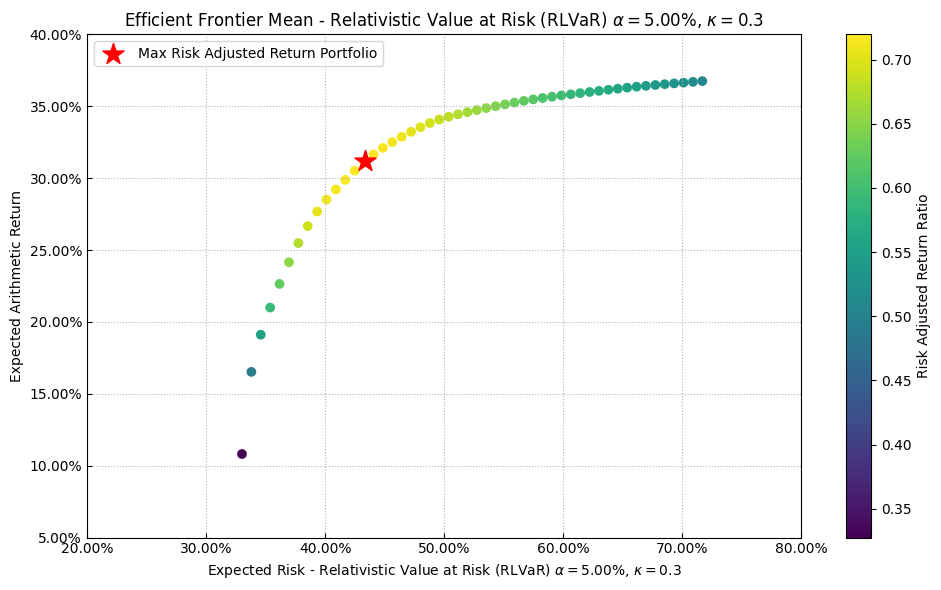

In [7]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier,
                      mu=mu,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=rf,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      cmap='viridis',
                      w=w,
                      label=label,
                      marker='*',
                      s=16,
                      c='r',
                      height=6,
                      width=10,
                      ax=None)

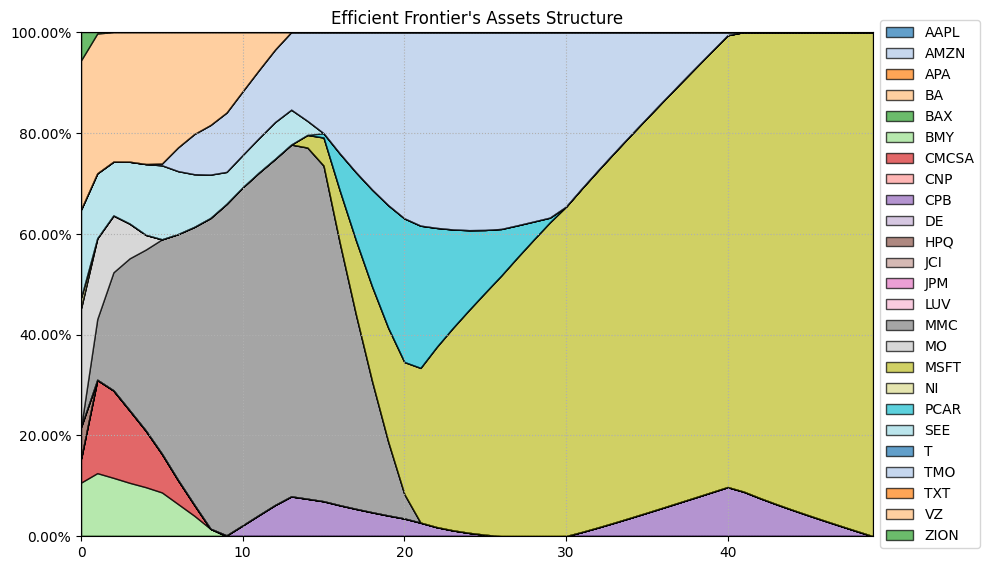

In [8]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for Relativistic Value at Risk

### 3.1 Calculating the risk parity portfolio for Relativistic Value at Risk.

In [9]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
weights,2.9693%,2.9937%,2.5752%,3.2822%,4.3365%,5.1403%,4.2069%,4.7291%,3.5354%,2.3535%,...,5.9295%,3.1232%,4.7398%,3.8010%,4.5658%,3.9264%,3.7370%,3.5493%,7.1581%,3.6839%


### 3.2 Plotting portfolio composition

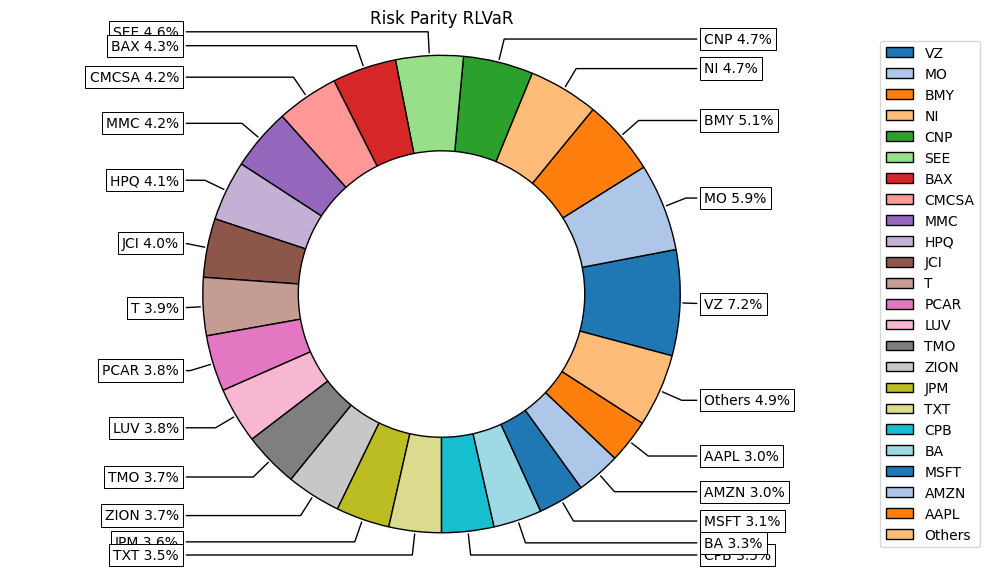

In [10]:
ax = rp.plot_pie(w=w_rp,
                 title='Risk Parity RLVaR',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=10,
                 ax=None)

### 3.3 Plotting Risk Composition

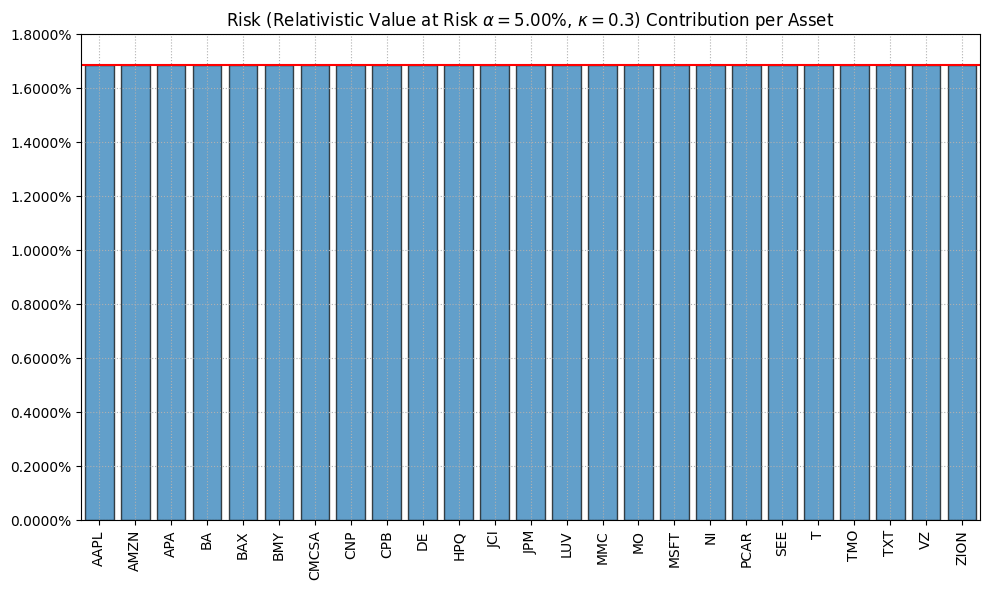

In [11]:
ax = rp.plot_risk_con(w_rp,
                      cov=port.cov,
                      returns=port.returns,
                      rm=rm,
                      rf=0,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      color="tab:blue", height=6, width=10, ax=None)

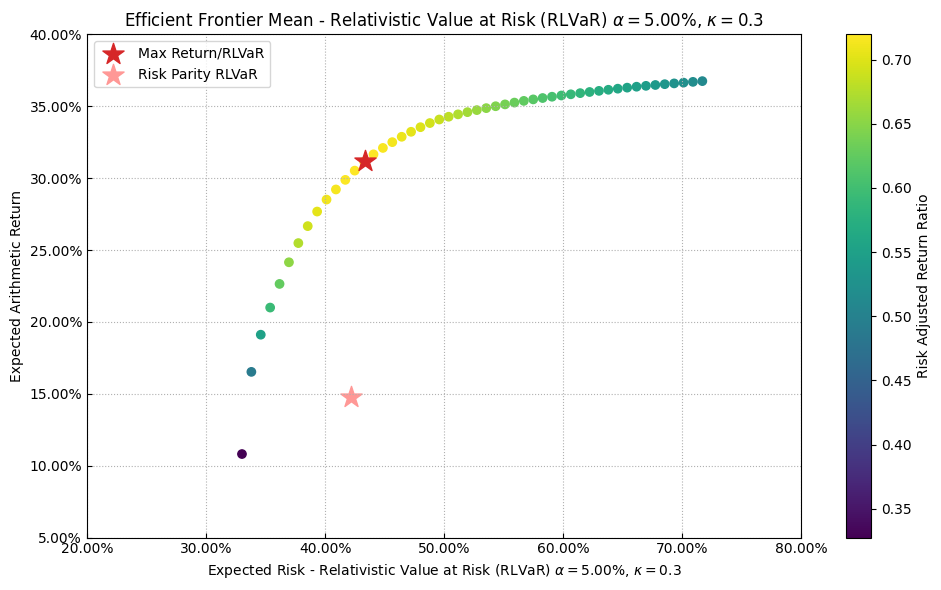

In [12]:
# Plotting the efficient frontier
ws = pd.concat([w, w_rp],axis=1)
ws.columns = ["Max Return/RLVaR", "Risk Parity RLVaR"]

mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier,
                      mu=mu,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=rf,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      cmap='viridis',
                      w=ws,
                      marker='*',
                      s=16,
                      height=6,
                      width=10,
                      ax=None)